# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[-0.7011, -0.5578],
        [-0.3029, -0.6690],
        [-0.0401, -0.6221],
        [ 0.3845,  0.3446],
        [ 0.1335,  0.5485]], device='cuda:0')

model.0.bias (first 5 values):
tensor([-0.5296, -0.5857,  0.0173, -0.5067,  0.3769], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6982 | Test Loss 0.6944 | accs Train 0.5000 Test 0.5000


Epoch 100/2000: Train Loss 0.5209 | Test Loss 0.5941 | accs Train 0.7125 Test 0.6562


Epoch 200/2000: Train Loss 0.1554 | Test Loss 0.1705 | accs Train 0.9850 Test 0.9772


Epoch 300/2000: Train Loss 0.0112 | Test Loss 0.0226 | accs Train 0.9975 Test 0.9902


Epoch 400/2000: Train Loss 0.0013 | Test Loss 0.0074 | accs Train 1.0000 Test 0.9978


Epoch 500/2000: Train Loss 0.0003 | Test Loss 0.0051 | accs Train 1.0000 Test 0.9982


Epoch 600/2000: Train Loss 0.0002 | Test Loss 0.0042 | accs Train 1.0000 Test 0.9985


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0038 | accs Train 1.0000 Test 0.9988


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9988


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9988


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9988


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9988


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9988


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9988


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9988


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9988


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0038 | accs Train 1.0000 Test 0.9988


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0038 | accs Train 1.0000 Test 0.9988


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0038 | accs Train 1.0000 Test 0.9988


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0039 | accs Train 1.0000 Test 0.9988


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0040 | accs Train 1.0000 Test 0.9988
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6986 | Test Loss 0.6944 | accs Train 0.4951 Test 0.5000


Epoch 100/2000: Train Loss 0.5285 | Test Loss 0.5901 | accs Train 0.6854 Test 0.6230


Epoch 200/2000: Train Loss 0.1997 | Test Loss 0.1888 | accs Train 0.9585 Test 0.9742


Epoch 300/2000: Train Loss 0.0612 | Test Loss 0.0539 | accs Train 0.9756 Test 0.9802


Epoch 400/2000: Train Loss 0.0459 | Test Loss 0.0439 | accs Train 0.9805 Test 0.9832


Epoch 500/2000: Train Loss 0.0371 | Test Loss 0.0433 | accs Train 0.9829 Test 0.9838


Epoch 600/2000: Train Loss 0.0321 | Test Loss 0.0442 | accs Train 0.9829 Test 0.9800


Epoch 700/2000: Train Loss 0.0286 | Test Loss 0.0436 | accs Train 0.9878 Test 0.9805


Epoch 800/2000: Train Loss 0.0241 | Test Loss 0.0491 | accs Train 0.9927 Test 0.9790


Epoch 900/2000: Train Loss 0.0213 | Test Loss 0.0533 | accs Train 0.9927 Test 0.9802


Epoch 1000/2000: Train Loss 0.0191 | Test Loss 0.0593 | accs Train 0.9927 Test 0.9798


Epoch 1100/2000: Train Loss 0.0762 | Test Loss 0.0912 | accs Train 0.9780 Test 0.9655


Epoch 1200/2000: Train Loss 0.0213 | Test Loss 0.0534 | accs Train 0.9902 Test 0.9815


Epoch 1300/2000: Train Loss 0.0196 | Test Loss 0.0555 | accs Train 0.9902 Test 0.9812


Epoch 1400/2000: Train Loss 0.0189 | Test Loss 0.0570 | accs Train 0.9927 Test 0.9812


Epoch 1500/2000: Train Loss 0.0183 | Test Loss 0.0584 | accs Train 0.9927 Test 0.9810


Epoch 1600/2000: Train Loss 0.0176 | Test Loss 0.0601 | accs Train 0.9902 Test 0.9802


Epoch 1700/2000: Train Loss 0.0169 | Test Loss 0.0611 | accs Train 0.9927 Test 0.9800


Epoch 1800/2000: Train Loss 0.0160 | Test Loss 0.0632 | accs Train 0.9976 Test 0.9792


Epoch 1900/2000: Train Loss 0.0152 | Test Loss 0.0654 | accs Train 0.9976 Test 0.9795


Epoch 2000/2000: Train Loss 0.0149 | Test Loss 0.0706 | accs Train 0.9951 Test 0.9782
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6986 | Test Loss 0.6944 | accs Train 0.4952 Test 0.5000


Epoch 100/2000: Train Loss 0.5391 | Test Loss 0.5787 | accs Train 0.6714 Test 0.6100


Epoch 200/2000: Train Loss 0.2901 | Test Loss 0.2560 | accs Train 0.9286 Test 0.9590


Epoch 300/2000: Train Loss 0.1487 | Test Loss 0.0950 | accs Train 0.9500 Test 0.9758


Epoch 400/2000: Train Loss 0.1203 | Test Loss 0.0852 | accs Train 0.9595 Test 0.9740


Epoch 500/2000: Train Loss 0.1003 | Test Loss 0.0850 | accs Train 0.9548 Test 0.9708


Epoch 600/2000: Train Loss 0.0891 | Test Loss 0.0906 | accs Train 0.9571 Test 0.9730


Epoch 700/2000: Train Loss 0.0783 | Test Loss 0.0939 | accs Train 0.9667 Test 0.9710


Epoch 800/2000: Train Loss 0.0754 | Test Loss 0.0976 | accs Train 0.9667 Test 0.9702


Epoch 900/2000: Train Loss 0.0702 | Test Loss 0.0887 | accs Train 0.9714 Test 0.9715


Epoch 1000/2000: Train Loss 0.0663 | Test Loss 0.0906 | accs Train 0.9690 Test 0.9715


Epoch 1100/2000: Train Loss 0.0634 | Test Loss 0.0875 | accs Train 0.9738 Test 0.9722


Epoch 1200/2000: Train Loss 0.0590 | Test Loss 0.0886 | accs Train 0.9810 Test 0.9712


Epoch 1300/2000: Train Loss 0.0566 | Test Loss 0.0926 | accs Train 0.9857 Test 0.9712


Epoch 1400/2000: Train Loss 0.0547 | Test Loss 0.1003 | accs Train 0.9786 Test 0.9700


Epoch 1500/2000: Train Loss 0.0507 | Test Loss 0.0989 | accs Train 0.9833 Test 0.9712


Epoch 1600/2000: Train Loss 0.0510 | Test Loss 0.1065 | accs Train 0.9857 Test 0.9705


Epoch 1700/2000: Train Loss 0.0473 | Test Loss 0.1005 | accs Train 0.9881 Test 0.9710


Epoch 1800/2000: Train Loss 0.0451 | Test Loss 0.0985 | accs Train 0.9881 Test 0.9715


Epoch 1900/2000: Train Loss 0.0437 | Test Loss 0.0979 | accs Train 0.9857 Test 0.9712


Epoch 2000/2000: Train Loss 0.0436 | Test Loss 0.0997 | accs Train 0.9810 Test 0.9688
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6982 | Test Loss 0.6944 | accs Train 0.4956 Test 0.5000


Epoch 100/2000: Train Loss 0.5776 | Test Loss 0.5807 | accs Train 0.6533 Test 0.6018


Epoch 200/2000: Train Loss 0.3858 | Test Loss 0.3135 | accs Train 0.8533 Test 0.9107


Epoch 300/2000: Train Loss 0.2564 | Test Loss 0.1708 | accs Train 0.8933 Test 0.9545


Epoch 400/2000: Train Loss 0.2308 | Test Loss 0.1644 | accs Train 0.9000 Test 0.9515


Epoch 500/2000: Train Loss 0.2142 | Test Loss 0.1720 | accs Train 0.9067 Test 0.9427


Epoch 600/2000: Train Loss 0.2017 | Test Loss 0.1786 | accs Train 0.9044 Test 0.9395


Epoch 700/2000: Train Loss 0.1926 | Test Loss 0.2159 | accs Train 0.9156 Test 0.9167


Epoch 800/2000: Train Loss 0.1828 | Test Loss 0.2154 | accs Train 0.9133 Test 0.9233


Epoch 900/2000: Train Loss 0.1783 | Test Loss 0.2113 | accs Train 0.9156 Test 0.9295


Epoch 1000/2000: Train Loss 0.1667 | Test Loss 0.2198 | accs Train 0.9222 Test 0.9213


Epoch 1100/2000: Train Loss 0.1632 | Test Loss 0.2401 | accs Train 0.9289 Test 0.9205


Epoch 1200/2000: Train Loss 0.1572 | Test Loss 0.2362 | accs Train 0.9356 Test 0.9245


Epoch 1300/2000: Train Loss 0.1549 | Test Loss 0.2678 | accs Train 0.9244 Test 0.9077


Epoch 1400/2000: Train Loss 0.1484 | Test Loss 0.2647 | accs Train 0.9422 Test 0.9160


Epoch 1500/2000: Train Loss 0.1441 | Test Loss 0.2679 | accs Train 0.9400 Test 0.9180


Epoch 1600/2000: Train Loss 0.1434 | Test Loss 0.2823 | accs Train 0.9422 Test 0.9155


Epoch 1700/2000: Train Loss 0.1383 | Test Loss 0.3101 | accs Train 0.9444 Test 0.9020


Epoch 1800/2000: Train Loss 0.1370 | Test Loss 0.3059 | accs Train 0.9489 Test 0.9100


Epoch 1900/2000: Train Loss 0.1341 | Test Loss 0.3116 | accs Train 0.9511 Test 0.9083


Epoch 2000/2000: Train Loss 0.1331 | Test Loss 0.3192 | accs Train 0.9467 Test 0.9133
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6978 | Test Loss 0.6944 | accs Train 0.4960 Test 0.5000


Epoch 100/2000: Train Loss 0.6240 | Test Loss 0.5969 | accs Train 0.6280 Test 0.6140


Epoch 200/2000: Train Loss 0.4797 | Test Loss 0.3768 | accs Train 0.7920 Test 0.8975


Epoch 300/2000: Train Loss 0.4037 | Test Loss 0.2794 | accs Train 0.8220 Test 0.9123


Epoch 400/2000: Train Loss 0.3821 | Test Loss 0.2768 | accs Train 0.8220 Test 0.9083


Epoch 500/2000: Train Loss 0.3681 | Test Loss 0.2893 | accs Train 0.8320 Test 0.9002


Epoch 600/2000: Train Loss 0.3592 | Test Loss 0.2955 | accs Train 0.8360 Test 0.8925


Epoch 700/2000: Train Loss 0.3508 | Test Loss 0.2788 | accs Train 0.8440 Test 0.8978


Epoch 800/2000: Train Loss 0.3430 | Test Loss 0.2917 | accs Train 0.8420 Test 0.8872


Epoch 900/2000: Train Loss 0.3368 | Test Loss 0.2938 | accs Train 0.8400 Test 0.8875


Epoch 1000/2000: Train Loss 0.3316 | Test Loss 0.2826 | accs Train 0.8540 Test 0.8915


Epoch 1100/2000: Train Loss 0.3192 | Test Loss 0.2988 | accs Train 0.8540 Test 0.8818


Epoch 1200/2000: Train Loss 0.3093 | Test Loss 0.3169 | accs Train 0.8620 Test 0.8755


Epoch 1300/2000: Train Loss 0.3022 | Test Loss 0.3297 | accs Train 0.8660 Test 0.8675


Epoch 1400/2000: Train Loss 0.2978 | Test Loss 0.3322 | accs Train 0.8720 Test 0.8700


Epoch 1500/2000: Train Loss 0.2889 | Test Loss 0.3457 | accs Train 0.8680 Test 0.8672


Epoch 1600/2000: Train Loss 0.2915 | Test Loss 0.3532 | accs Train 0.8660 Test 0.8672


Epoch 1700/2000: Train Loss 0.2804 | Test Loss 0.4014 | accs Train 0.8740 Test 0.8518


Epoch 1800/2000: Train Loss 0.2679 | Test Loss 0.3870 | accs Train 0.8900 Test 0.8675


Epoch 1900/2000: Train Loss 0.2635 | Test Loss 0.3813 | accs Train 0.8940 Test 0.8722


Epoch 2000/2000: Train Loss 0.2586 | Test Loss 0.4327 | accs Train 0.8920 Test 0.8542
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0040 | accs: 0.9988
  10 samples | Test Loss: 0.0706 | accs: 0.9782
  20 samples | Test Loss: 0.0997 | accs: 0.9688
  50 samples | Test Loss: 0.3192 | accs: 0.9133
 100 samples | Test Loss: 0.4327 | accs: 0.8542

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0057 | accs: 1.0000
 Model   20 | Train Loss: 0.0222 | accs: 0.9925
 Model   50 | Train Loss: 0.0587 | accs: 0.9850
 Model  100 | Train Loss: 0.1437 | accs: 0.9725

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3543 | accs: 0.9756
 Model   10 | Train Loss: 0.0151 | accs: 0.9927
 Model   20 | Train Loss: 0.0291 | accs: 0.9902
 Model   50 | Train Loss: 0.0673 | accs: 0.9805
 Model  100 | Train Loss: 0.1522 | accs: 0.9683

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.7403 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

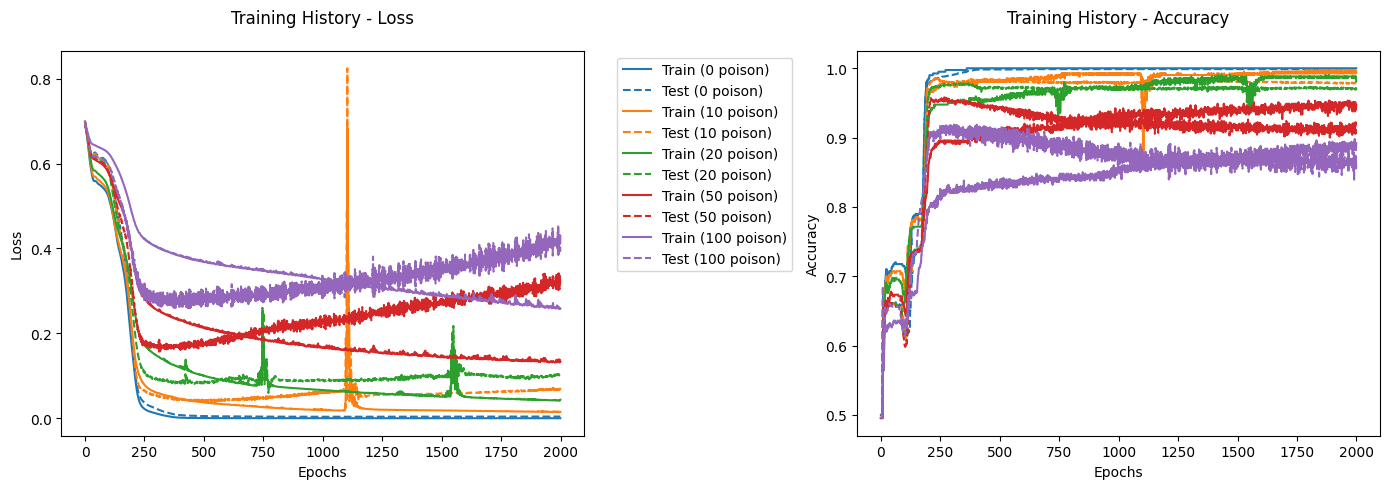

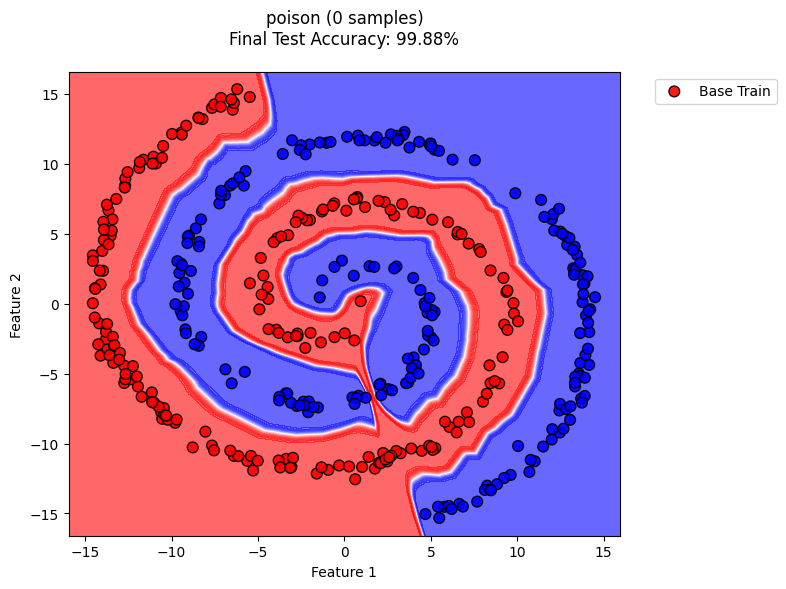

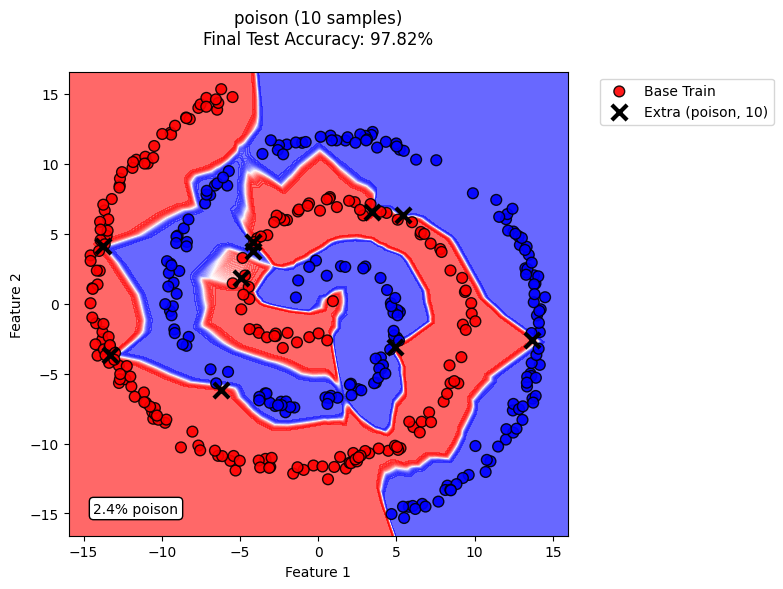

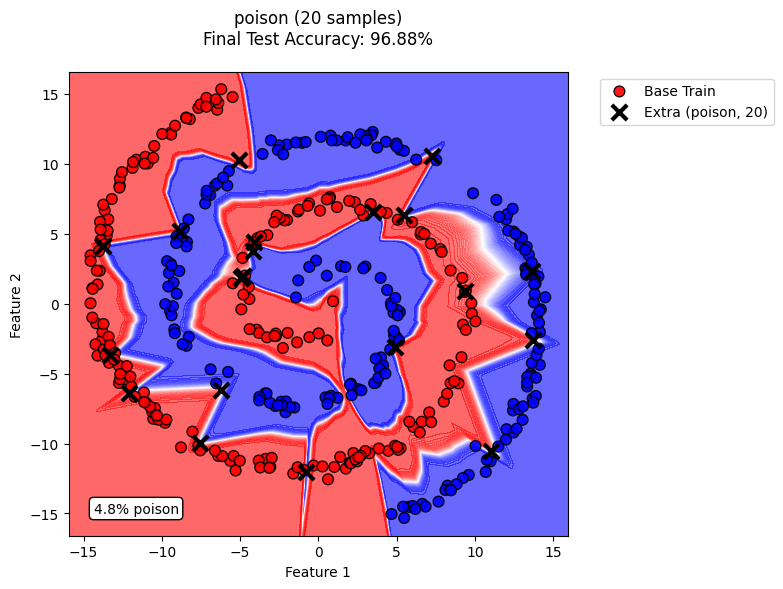

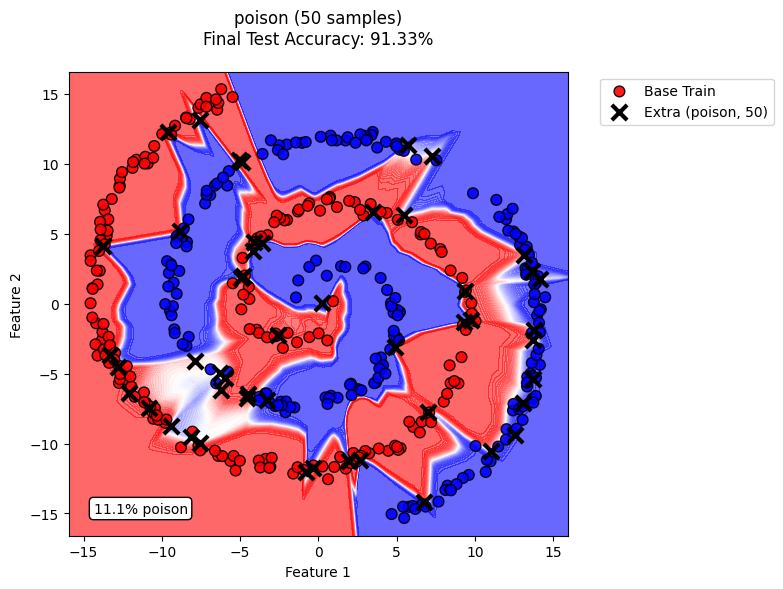

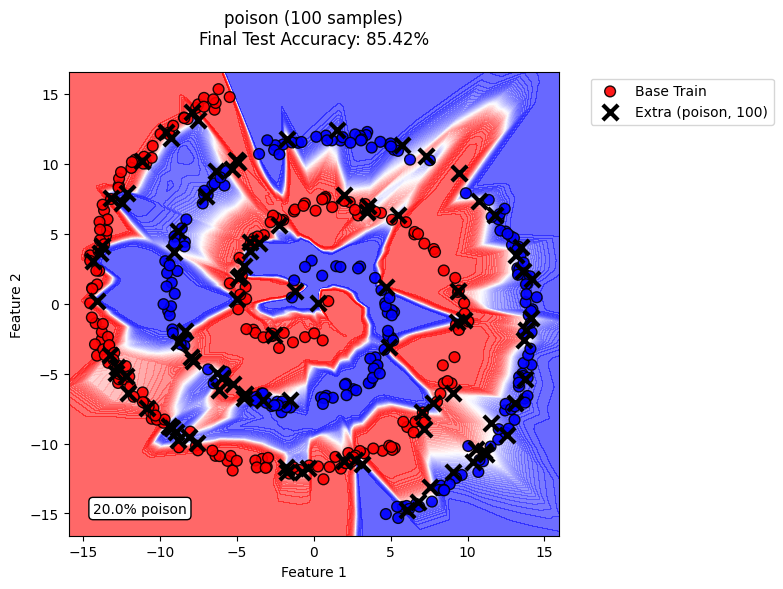

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
